In [1]:
import numpy as np
import pandas as pd
import scipy as scipy
import tensorflow 
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import tensorflow as tf
import imutils
import cv2
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing

/Users/nitomar/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
loss_data = [2.706779,2.7038312,2.6973665,2.6867313,2.6697323,2.6415536,2.599275,2.5390034,2.4574227,2.352549,2.2266202,2.0886116,1.9458257,1.8013884,1.6673236,1.4336776,1.2816248,1.1347898,0.99126416,0.8799928,0.83354485,0.76377654,0.63008034,0.62085265,0.54507244,0.5482338,0.4975817,0.446424,0.4111096,0.37561345,0.33219647,0.30317387,0.28258038,0.23271303,0.21971571,0.18590324,0.16160698,0.14524205,0.117653705,0.10730177,0.08622139,0.0748082,0.06139506,0.054580554,0.05061849]

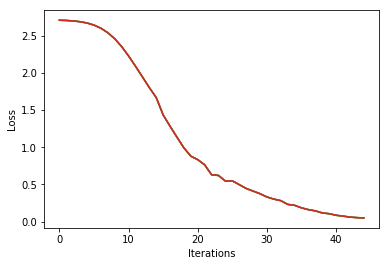

In [6]:
plt.plot(loss_data)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.show()

In [2]:
df_business = pd.read_json("/Users/nitomar/Downloads/business.json", lines=True)
s=0
e=15

In [3]:
C = df_business['categories']
ID = df_business['business_id']

In [4]:
business_ids = []
business_categories = []
for i in range(len(C)):
    if 'Restaurants' in C[i]:
        business_ids.append(ID[i])
        business_categories.append(C[i])

In [5]:
df_photos = pd.read_json("/Users/nitomar/Downloads/yelp_photos/photos.json", lines=True)
print(df_photos.shape)

(206949, 4)


In [6]:
df_photos = df_photos.loc[df_photos['label'] == 'food']
print(df_photos.shape)

(132354, 4)


In [7]:
import os
image_size = 256
images_path = ["/Users/nitomar/Downloads/yelp_photos/photos/"+x for x in df_photos['photo_id']+".jpg"]
train_images=[]
channels = 3

In [8]:
photo_id_to_business = [id for id in df_photos['business_id']]
business_id_classes = [i for i in range(len(photo_id_to_business))][s:e]
#print((business_id_classes[:15]))

In [9]:
for image_path in images_path[s:e]:
    image = cv2.imread(image_path)
    image = cv2.resize(image, (image_size, image_size), cv2.INTER_LINEAR)
    #image = image.reshape(200, image_size,image_size,channels)
    train_images.append(image)
train_images = np.array(train_images, dtype=np.uint8)
train_images = train_images.astype('float32')
train_images = np.multiply(train_images, 1.0/255.0) 
#train_images = train_images.reshape(1, image_size,image_size,channels)

In [10]:
import matplotlib.image as mpimg
def resize_tensorflow_images(img_file_paths):
    X_data = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, (None, None, 3))
    tf_img = tf.image.resize_images(X, (256, 256), tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        # Each image is resized individually as different image may be of different size.
        for file_path in img_file_paths:
            img = mpimg.imread(file_path)[:, :, :3] # Do not read alpha channel.
            resized_img = sess.run(tf_img, feed_dict = {X: img})
            X_data.append(resized_img)

    X_data = np.array(X_data, dtype = np.uint8) # Convert to numpy
    return X_data

In [11]:
train_photos = resize_tensorflow_images(images_path[s:e])
print(train_photos.shape)

(15, 256, 256, 3)


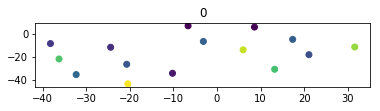

In [12]:
from sklearn.manifold import TSNE
tsne5 = train_photos[s:e].reshape(e-s,-1)
for x in range(1):
    model = TSNE(learning_rate=100, n_components=2, random_state=0, perplexity=10)
    tsne5 = model.fit_transform(tsne5)

    plt.figure(1)

    plt.subplot(311)
    plt.scatter(tsne5[:,0], tsne5[:, 1], c=np.random.rand(e-s,))
    plt.title(str(x))

    plt.show()

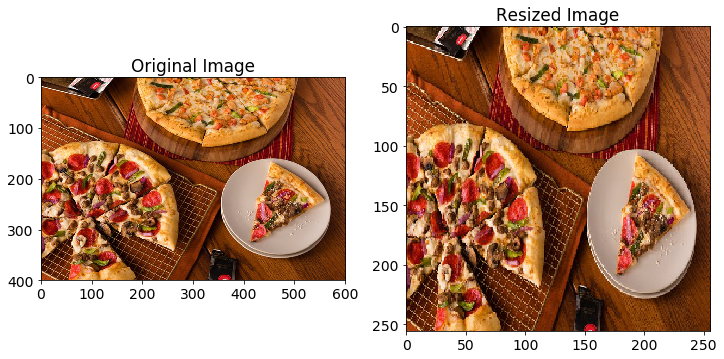

In [13]:
matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize = (12, 12))
plt.subplot(1, 2, 1)
plt.imshow(mpimg.imread(images_path[0])[:,:,:3])
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(train_photos[0])
plt.title('Resized Image')
plt.show()

In [14]:
business_id_scale = []
def central_scale_images(X_imgs, scales):
    boxes = np.zeros((len(scales), 4), dtype = np.float32)
    for index, scale in enumerate(scales):
        x1 = y1 = 0.5 - 0.5 * scale # To scale centrally
        x2 = y2 = 0.5 + 0.5 * scale
        boxes[index] = np.array([y1, x1, y2, x2], dtype = np.float32)
    box_ind = np.zeros((len(scales)), dtype = np.int32)
    crop_size = np.array([256, 256], dtype = np.int32)
    
    X_scale_data = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (1, 256, 256, 3))
    # Define Tensorflow operation for all scales but only one base image at a time
    tf_img = tf.image.crop_and_resize(X, boxes, box_ind, crop_size)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer()) 
        bus_class = 0
        for img_data in X_imgs:
            for _ in range(3):
                business_id_scale.append(business_id_classes[bus_class])
            bus_class+=1
            batch_img = np.expand_dims(img_data, axis = 0)
            scaled_imgs = sess.run(tf_img, feed_dict = {X: batch_img})
            X_scale_data.extend(scaled_imgs)
    
    X_scale_data = np.array(X_scale_data, dtype = np.uint8)
    return X_scale_data

scaled_imgs = central_scale_images(train_photos, [0.90, 0.75, 0.60])
print(scaled_imgs.shape)

(45, 256, 256, 3)


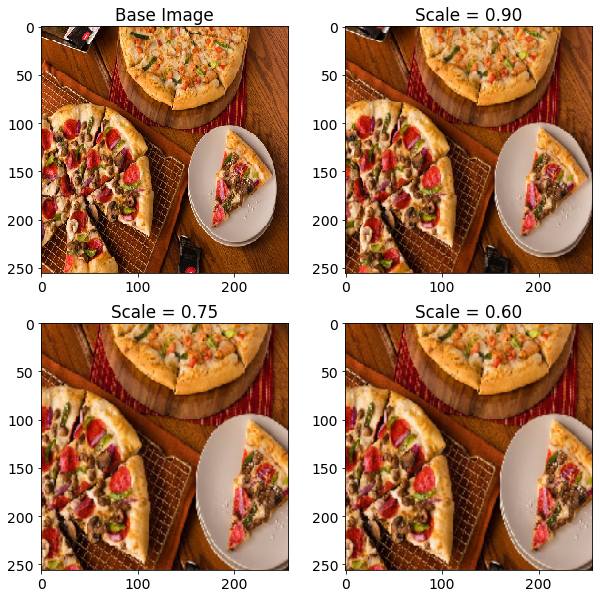

In [15]:
fig, ax = plt.subplots(figsize = (10, 10))
plt.subplot(2, 2, 1)
plt.imshow(train_photos[0])
plt.title('Base Image')
plt.subplot(2, 2, 2)
plt.imshow(scaled_imgs[0])
plt.title('Scale = 0.90')
plt.subplot(2, 2, 3)
plt.imshow(scaled_imgs[1])
plt.title('Scale = 0.75')
plt.subplot(2, 2, 4)
plt.imshow(scaled_imgs[1])
plt.title('Scale = 0.60')
plt.show()
#print((business_id_scale[:6]),business_id_classes[:6])

In [16]:
from math import ceil, floor
image_dim = 256
business_id_translate = []
def get_translate_parameters(index):
    if index == 0: # Translate left 20 percent
        offset = np.array([0.0, 0.2], dtype = np.float32)
        size = np.array([image_dim, ceil(0.8 * image_dim)], dtype = np.int32)
        w_start = 0
        w_end = int(ceil(0.8 * image_dim))
        h_start = 0
        h_end = image_dim
    elif index == 1: # Translate right 20 percent
        offset = np.array([0.0, -0.2], dtype = np.float32)
        size = np.array([image_dim, ceil(0.8 * image_dim)], dtype = np.int32)
        w_start = int(floor((1 - 0.8) * image_dim))
        w_end = image_dim
        h_start = 0
        h_end = image_dim
    elif index == 2: # Translate top 20 percent
        offset = np.array([0.2, 0.0], dtype = np.float32)
        size = np.array([ceil(0.8 * image_dim), image_dim], dtype = np.int32)
        w_start = 0
        w_end = image_dim
        h_start = 0
        h_end = int(ceil(0.8 * image_dim)) 
    else: # Translate bottom 20 percent
        offset = np.array([-0.2, 0.0], dtype = np.float32)
        size = np.array([ceil(0.8 * image_dim), image_dim], dtype = np.int32)
        w_start = 0
        w_end = image_dim
        h_start = int(floor((1 - 0.8) * image_dim))
        h_end = image_dim 
        
    return offset, size, w_start, w_end, h_start, h_end

def translate_images(X_imgs):
    offsets = np.zeros((len(X_imgs), 2), dtype = np.uint8)
    n_translations = 4
    X_translated_arr = []
    
    tf.reset_default_graph()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(n_translations):
            X_translated = np.zeros((len(X_imgs), image_dim, image_dim, 3), dtype = np.float32)
            X_translated.fill(1.0) # Filling background color
            base_offset, size, w_start, w_end, h_start, h_end = get_translate_parameters(i)
            offsets[:, :] = base_offset 
            glimpses = tf.image.extract_glimpse(X_imgs, size, offsets)
            
            glimpses = sess.run(glimpses)
            X_translated[:, h_start: h_start + size[0], w_start: w_start + size[1], :] = glimpses
            X_translated_arr.extend(X_translated)
    X_translated_arr = np.array(X_translated_arr, dtype = np.uint8)
    return X_translated_arr

(60, 256, 256, 3)


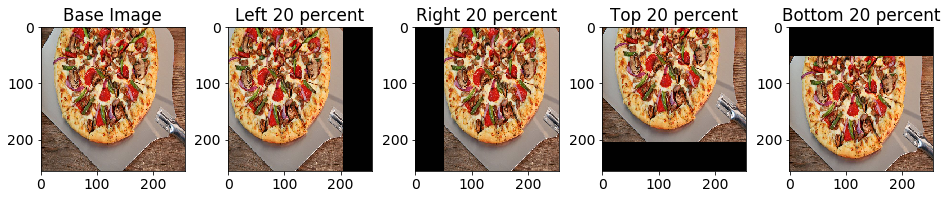

In [17]:
translated_imgs = translate_images(train_photos)
for _ in range(4):
    for x in range(len(train_photos)):
        business_id_translate.append(business_id_classes[x])
print(translated_imgs.shape)
gs = gridspec.GridSpec(1, 5)
gs.update(wspace = 0.30, hspace = 2)

fig, ax = plt.subplots(figsize = (16, 16))
plt.subplot(gs[0])
plt.imshow(train_photos[2])
plt.title('Base Image')
plt.subplot(gs[1])
plt.imshow(translated_imgs[2])
plt.title('Left 20 percent')
plt.subplot(gs[2])
plt.imshow(translated_imgs[17])
plt.title('Right 20 percent')
plt.subplot(gs[3])
plt.imshow(translated_imgs[32])
plt.title('Top 20 percent')
plt.subplot(gs[4])
plt.imshow(translated_imgs[47])
plt.title('Bottom 20 percent')
plt.show()

In [18]:
def rotate_images(X_imgs):
    X_rotate = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (image_dim, image_dim, 3))
    k = tf.placeholder(tf.int32)
    tf_img = tf.image.rot90(X, k = k)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for img in X_imgs:
            for i in range(3):  # Rotation at 90, 180 and 270 degrees
                rotated_img = sess.run(tf_img, feed_dict = {X: img, k: i + 1})
                X_rotate.append(rotated_img)
        
    X_rotate = np.array(X_rotate, dtype = np.uint8)
    return X_rotate

(45, 256, 256, 3)


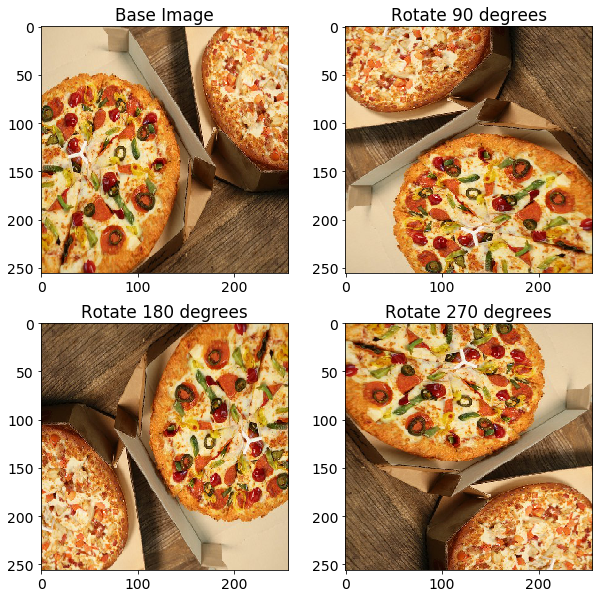

In [19]:
rotated_imgs = rotate_images(train_photos)
business_id_rotate = []
for x in range(len(business_id_classes)):
    for _ in range(3):
        business_id_rotate.append(business_id_classes[x])
print(rotated_imgs.shape)
fig, ax = plt.subplots(figsize = (10, 10))
plt.subplot(2, 2, 1)
plt.imshow(train_photos[1])
plt.title('Base Image')
plt.subplot(2, 2, 2)
plt.imshow(rotated_imgs[3])
plt.title('Rotate 90 degrees')
plt.subplot(2, 2, 3)
plt.imshow(rotated_imgs[4])
plt.title('Rotate 180 degrees')
plt.subplot(2, 2, 4)
plt.imshow(rotated_imgs[5])
plt.title('Rotate 270 degrees')
plt.show()

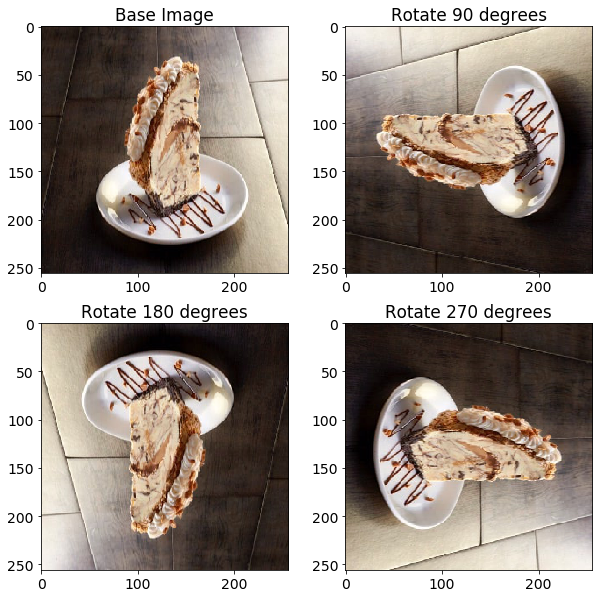

In [20]:
fig, ax = plt.subplots(figsize = (10, 10))
plt.subplot(2, 2, 1)
plt.imshow(train_photos[8])
plt.title('Base Image')
plt.subplot(2, 2, 2)
plt.imshow(rotated_imgs[24])
plt.title('Rotate 90 degrees')
plt.subplot(2, 2, 3)
plt.imshow(rotated_imgs[25])
plt.title('Rotate 180 degrees')
plt.subplot(2, 2, 4)
plt.imshow(rotated_imgs[26])
plt.title('Rotate 270 degrees')
plt.show()

In [21]:
import math
def rotate_images(X_imgs, start_angle, end_angle, n_images):
    X_rotate = []
    iterate_at = (end_angle - start_angle) / (n_images - 1)
    
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (None, image_dim, image_dim, 3))
    radian = tf.placeholder(tf.float32, shape = (len(X_imgs)))
    tf_img = tf.contrib.image.rotate(X, radian)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
    
        for index in range(n_images):
            degrees_angle = start_angle + index * iterate_at
            radian_value = degrees_angle * math.pi / 180  
            radian_arr = [radian_value] * len(X_imgs)
            rotated_imgs = sess.run(tf_img, feed_dict = {X: X_imgs, radian: radian_arr})
            X_rotate.extend(rotated_imgs)

    X_rotate = np.array(X_rotate, dtype = np.uint8)
    return X_rotate

Instructions for updating:
Use the retry module or similar alternatives.
(210, 256, 256, 3)


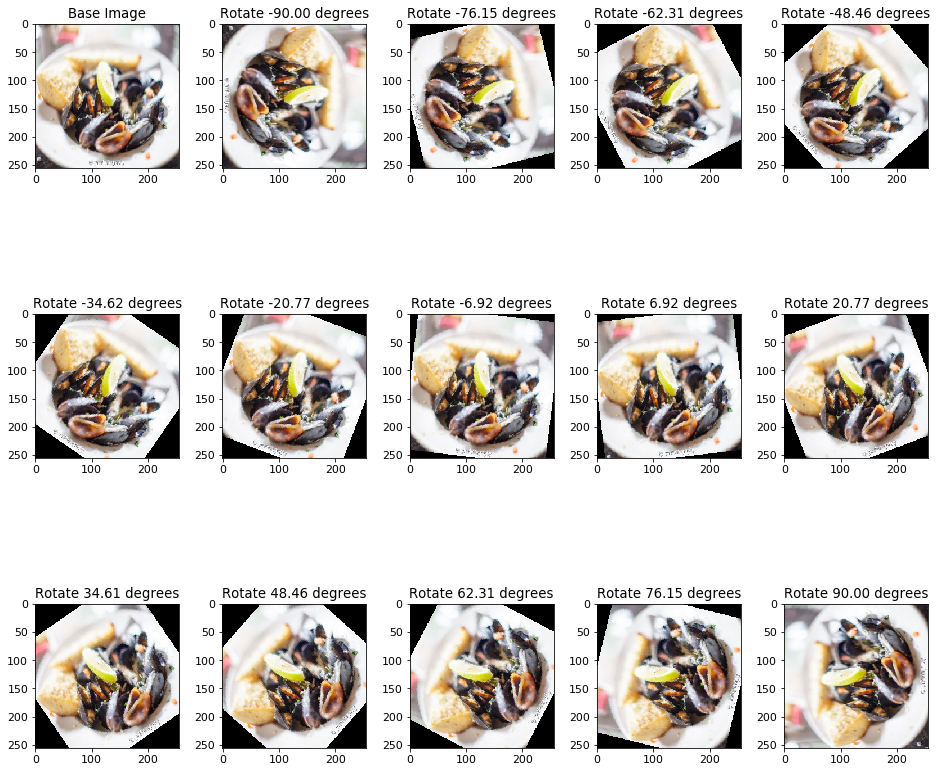

In [22]:
rotated_imgs1 = rotate_images(train_photos, -90, 90, 14)
business_id_rotate1 = []
for _ in range(14):    
    for x in range(len(business_id_classes)):
        business_id_rotate1.append(business_id_classes[x])
print(rotated_imgs1.shape)
matplotlib.rcParams.update({'font.size': 11})

fig, ax = plt.subplots(figsize = (16, 16))
gs = gridspec.GridSpec(3, 5)
gs.update(wspace = 0.30, hspace = 0.0002)

plt.subplot(gs[0])
plt.imshow(train_photos[9])
plt.title('Base Image')

for i in range(14):
    plt.subplot(gs[i + 1])
    plt.imshow(rotated_imgs1[9 + 15 * i])
    plt.title('Rotate {:.2f} degrees'.format(-90 + 13.846 * i))
plt.show()

In [23]:
def flip_images(X_imgs):
    X_flip = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (image_dim, image_dim, 3))
    tf_img1 = tf.image.flip_left_right(X)
    tf_img2 = tf.image.flip_up_down(X)
    tf_img3 = tf.image.transpose_image(X)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for img in X_imgs:
            flipped_imgs = sess.run([tf_img1, tf_img2, tf_img3], feed_dict = {X: img})
            X_flip.extend(flipped_imgs)
    X_flip = np.array(X_flip, dtype = np.uint8)
    return X_flip

(45, 256, 256, 3)
(45, 256, 256, 3)


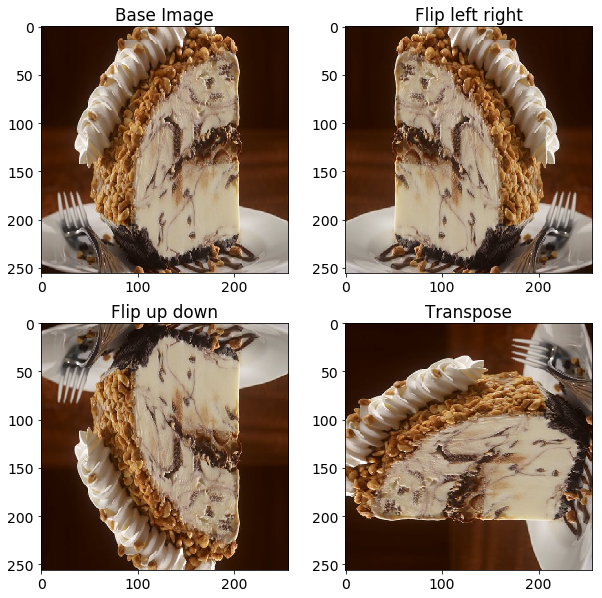

In [24]:
flipped_images = flip_images(train_photos)
business_id_flip = []
for x in range(len(business_id_classes)):
    for _ in range(3):
        business_id_flip.append(business_id_classes[x])
print(rotated_imgs.shape)
print(flipped_images.shape)

matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize = (10, 10))
plt.subplot(2, 2, 1)
plt.imshow(train_photos[6])
plt.title('Base Image')
plt.subplot(2, 2, 2)
plt.imshow(flipped_images[18])
plt.title('Flip left right')
plt.subplot(2, 2, 3)
plt.imshow(flipped_images[19])
plt.title('Flip up down')
plt.subplot(2, 2, 4)
plt.imshow(flipped_images[20])
plt.title('Transpose')
plt.show()

In [25]:
def add_salt_pepper_noise(X_imgs):
    # Need to produce a copy as to not modify the original image
    X_imgs_copy = X_imgs.copy()
    row, col, _ = X_imgs_copy[0].shape
    salt_vs_pepper = 0.2
    amount = 0.004
    num_salt = np.ceil(amount * X_imgs_copy[0].size * salt_vs_pepper)
    num_pepper = np.ceil(amount * X_imgs_copy[0].size * (1.0 - salt_vs_pepper))
    
    for X_img in X_imgs_copy:
        # Add Salt noise
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in X_img.shape]
        X_img[coords[0], coords[1], :] = 1

        # Add Pepper noise
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in X_img.shape]
        X_img[coords[0], coords[1], :] = 0
    return X_imgs_copy

(15, 256, 256, 3)


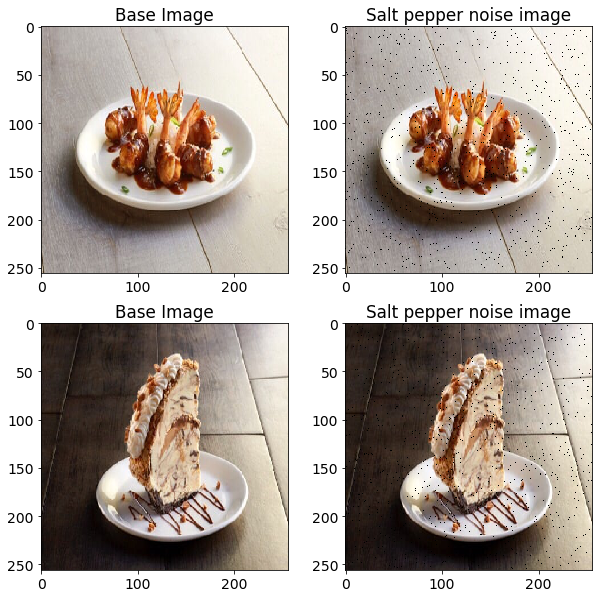

In [26]:
salt_pepper_noise_imgs = add_salt_pepper_noise(train_photos)
business_id_sall_pepper = business_id_classes[:]
print(salt_pepper_noise_imgs.shape)
fig, ax = plt.subplots(figsize = (10, 10))
plt.subplot(2, 2, 1)
plt.imshow(train_photos[7])
plt.title('Base Image')
plt.subplot(2, 2, 2)
plt.imshow(salt_pepper_noise_imgs[7])
plt.title('Salt pepper noise image')
plt.subplot(2, 2, 3)
plt.imshow(train_photos[8])
plt.title('Base Image')
plt.subplot(2, 2, 4)
plt.imshow(salt_pepper_noise_imgs[8])
plt.title('Salt pepper noise image')
plt.show()

In [27]:
def get_mask_coord(imshape):
    vertices = np.array([[(0.09 * imshape[1], 0.99 * imshape[0]), 
                          (0.43 * imshape[1], 0.32 * imshape[0]), 
                          (0.56 * imshape[1], 0.32 * imshape[0]),
                          (0.85 * imshape[1], 0.99 * imshape[0])]], dtype = np.int32)
#    vertices = np.array([[(0.29 * imshape[1], 0.99 * imshape[0]), 
#                          (0.53 * imshape[1], 0.52 * imshape[0]), 
#                          (0.66 * imshape[1], 0.52 * imshape[0]),
#                          (0.85 * imshape[1], 0.99 * imshape[0])]], dtype = np.int32)
    return vertices

def get_perspective_matrices(X_img):
    offset = 15
    img_size = (X_img.shape[1], X_img.shape[0])

    # Estimate the coordinates of object of interest inside the image.
    src = np.float32(get_mask_coord(X_img.shape))
    dst = np.float32([[offset, img_size[1]], [offset, 0], [img_size[0] - offset, 0], 
                      [img_size[0] - offset, img_size[1]]])
    
    perspective_matrix = cv2.getPerspectiveTransform(src, dst)
    return perspective_matrix

def perspective_transform(X_img):
    # Doing only for one type of example
    perspective_matrix = get_perspective_matrices(X_img)
    warped_img = cv2.warpPerspective(X_img, perspective_matrix,
                                     (X_img.shape[1], X_img.shape[0]),
                                     flags = cv2.INTER_LINEAR)
    return warped_img

(15, 256, 256, 3)


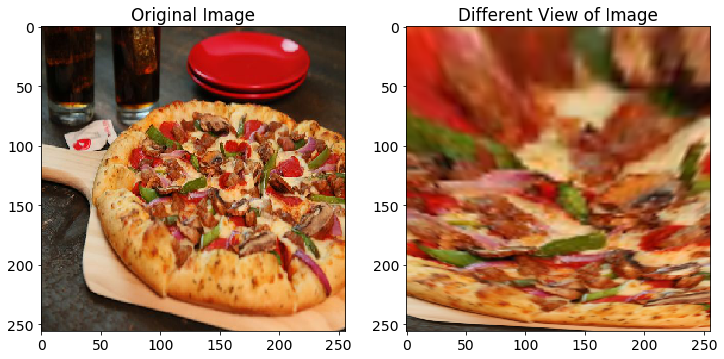

In [28]:
perspective_imgs = []
for X_img in train_photos:
    perspective_imgs.append(perspective_transform(X_img))
perspective_imgs = np.array(perspective_imgs, dtype = np.uint8)
business_id_perspective = business_id_classes[:]
print(perspective_imgs.shape)
fig, ax = plt.subplots(figsize = (12, 12))
plt.subplot(1, 2, 1)
plt.imshow(train_photos[5])
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(perspective_imgs[5])
plt.title('Different View of Image')
plt.show()

In [29]:
for x in business_id_scale:
    business_id_classes.append(x)
for x in business_id_flip:
    business_id_classes.append(x)
for x in business_id_perspective:
    business_id_classes.append(x)
for x in business_id_rotate:
    business_id_classes.append(x)
for x in business_id_rotate1:
    business_id_classes.append(x)
for x in business_id_sall_pepper:
    business_id_classes.append(x)
for x in business_id_translate:
    business_id_classes.append(x)
#num_classes = len(set(business_id_classes))
print(len(business_id_classes))

450


In [30]:
train_photos = np.append(train_photos, scaled_imgs, axis=0)
train_photos = np.append(train_photos, flipped_images, axis=0)
train_photos = np.append(train_photos, perspective_imgs, axis=0)
train_photos = np.append(train_photos, rotated_imgs, axis=0)
train_photos = np.append(train_photos, rotated_imgs1, axis=0)
train_photos = np.append(train_photos, salt_pepper_noise_imgs, axis=0)
train_photos = np.append(train_photos, translated_imgs, axis=0)

In [31]:
#train_photos = np.append(train_photos, [scaled_imgs])
print(len((train_photos)))
print(len(business_id_classes))
num_classes = len(set(business_id_classes))
print(num_classes)
lb = preprocessing.LabelBinarizer()
transformed_label = lb.fit_transform(business_id_classes)
print(transformed_label.shape)

450
450
15
(450, 15)


In [32]:
def layer_weights(dimensions):
    return tensorflow.Variable(tensorflow.truncated_normal(dimensions, stddev=1./math.sqrt(256*256)))
    #return tensorflow.Variable(tensorflow.truncated_normal([256, 10],
                       #             stddev=1./math.sqrt(256)))
def layer_biases(size):
    return tensorflow.Variable(tensorflow.constant(0.05, shape=[size]))

In [33]:
def make_cnn_layer(input_data,num_of_input_channels,filter_size,num_of_filters):  
    cnn_weights = layer_weights([filter_size,filter_size, num_of_input_channels,num_of_filters])
    cnn_biases = layer_biases(num_of_filters)
    cnn_layer = tensorflow.nn.conv2d(input=input_data,filter=cnn_weights,
                                     strides=[1, 1, 1, 1],padding='SAME') 
    cnn_layer += cnn_biases
    cnn_layer = tensorflow.nn.max_pool(value=cnn_layer,ksize=[1, 2, 2, 1],
                                    strides=[1, 2, 2, 1],padding='SAME')
    cnn_layer = tensorflow.nn.relu(cnn_layer)
    return cnn_layer

In [34]:
def create_fully_conn_layer(input_data,num_of_inputs,num_of_outputs,RELU_FLAG):
    fc_weights = layer_weights([num_of_inputs, num_of_outputs])
    fc_biases = layer_biases(num_of_outputs)
    fc_layer = tensorflow.matmul(input_data, fc_weights) + fc_biases
    if RELU_FLAG:
        fc_layer = tensorflow.nn.relu(fc_layer)
    return fc_layer

In [35]:
def flatten_cnn_layer(layer):
    layershape = layer.get_shape()
    num_of_features = layershape[1:4].num_elements()
    flat_layer = tensorflow.reshape(layer, [-1, num_of_features])
    return flat_layer

In [36]:
x = tensorflow.placeholder(tensorflow.float32, shape=[None, 256,256,3], name='x')
y_true = tensorflow.placeholder(tensorflow.float32, shape=[None,num_classes], name='y_true')
y_true_cls = tensorflow.argmax(y_true, dimension=1)
channels = 3
filter_size_conv1=3
filter_size_conv2=3
filter_size_conv3=3
num_filters_conv1=64
num_filters_conv2=64
num_filters_conv3=128
fc_layer_size = 256

Instructions for updating:
Use the `axis` argument instead


In [37]:
layer1 = make_cnn_layer(x,channels,filter_size_conv1,num_filters_conv1)
layer2 = make_cnn_layer(layer1,num_filters_conv1,filter_size_conv2,num_filters_conv2)
layer3 = make_cnn_layer(layer2,num_filters_conv2,filter_size_conv3,num_filters_conv3)
layer_flat = flatten_cnn_layer(layer3)
layer_fc1 = create_fully_conn_layer(layer_flat,layer_flat.get_shape()[1:4].num_elements(),fc_layer_size,True)
layer_fc2 = create_fully_conn_layer(layer_fc1,fc_layer_size,num_classes,False)

In [38]:
num_of_iter = 15
feed_dict_tr = {x: train_photos,
                       y_true: transformed_label}
y_pred = tensorflow.nn.softmax(layer_fc2,name='y_pred')
y_pred_cls = tensorflow.argmax(y_pred, dimension=1)
session = tensorflow.Session()
cross_entropy = tensorflow.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2,
                                                    labels=y_true)
tensor_cost = tensorflow.reduce_mean(cross_entropy)
optimizer = tensorflow.train.AdamOptimizer(learning_rate=1e-4).minimize(tensor_cost)
correct_prediction = tensorflow.equal(y_pred_cls, y_true_cls)
session.run(tensorflow.global_variables_initializer())
accuracy = tensorflow.reduce_mean(tensorflow.cast(correct_prediction, tensorflow.float32))
for iterations in range(num_of_iter):
    session.run(optimizer, feed_dict=feed_dict_tr)
    eval_loss = session.run(tensor_cost,
                                         feed_dict=feed_dict_tr) 
    print("Iteration -",iterations,"; Loss - ", eval_loss)

Iteration - 0 ; Loss -  2.706779
Iteration - 1 ; Loss -  2.7038312
Iteration - 2 ; Loss -  2.6973665
Iteration - 3 ; Loss -  2.6867313
Iteration - 4 ; Loss -  2.6697323
Iteration - 5 ; Loss -  2.6415536
Iteration - 6 ; Loss -  2.599275
Iteration - 7 ; Loss -  2.5390034
Iteration - 8 ; Loss -  2.4574227
Iteration - 9 ; Loss -  2.352549
Iteration - 10 ; Loss -  2.2266202
Iteration - 11 ; Loss -  2.0886116
Iteration - 12 ; Loss -  1.9458257
Iteration - 13 ; Loss -  1.8013884
Iteration - 14 ; Loss -  1.6673236


In [48]:
saver = tensorflow.train.Saver()
saver.save(session, '/Users/nitomar/Desktop/SP - 18/Project/photo_to_business_model')

'/Users/nitomar/Desktop/SP - 18/Project/photo_to_business_model'

In [43]:
for iterations in range(25,35):
    session.run(optimizer, feed_dict=feed_dict_tr)
    eval_loss = session.run(tensor_cost,
                                         feed_dict=feed_dict_tr) 
    print("Iteration -",iterations,"; Loss - ", eval_loss)

Iteration - 25 ; Loss -  0.5482338
Iteration - 26 ; Loss -  0.4975817
Iteration - 27 ; Loss -  0.446424
Iteration - 28 ; Loss -  0.4111096
Iteration - 29 ; Loss -  0.37561345
Iteration - 30 ; Loss -  0.33219647
Iteration - 31 ; Loss -  0.30317387
Iteration - 32 ; Loss -  0.28258038
Iteration - 33 ; Loss -  0.23271303
Iteration - 34 ; Loss -  0.21971571


In [45]:
for iterations in range(35,40):
    session.run(optimizer, feed_dict=feed_dict_tr)
    eval_loss = session.run(tensor_cost,
                                         feed_dict=feed_dict_tr) 
    print("Iteration -",iterations,"; Loss - ", eval_loss)

Iteration - 35 ; Loss -  0.18590324
Iteration - 36 ; Loss -  0.16160698
Iteration - 37 ; Loss -  0.14524205
Iteration - 38 ; Loss -  0.117653705
Iteration - 39 ; Loss -  0.10730177


In [47]:
for iterations in range(40,45):
    session.run(optimizer, feed_dict=feed_dict_tr)
    eval_loss = session.run(tensor_cost,
                                         feed_dict=feed_dict_tr) 
    print("Iteration -",iterations,"; Loss - ", eval_loss)

Iteration - 40 ; Loss -  0.08622139
Iteration - 41 ; Loss -  0.0748082
Iteration - 42 ; Loss -  0.06139506
Iteration - 43 ; Loss -  0.054580554
Iteration - 44 ; Loss -  0.05061849


In [ ]:
saver = tensorflow.train.Saver()
saver.save(session, '/Users/nitomar/Desktop/SP - 18/Project/photo_to_business_model')

In [49]:
image_size=256
num_channels=3
images = []
image_id = "876EKnk6deA7xA4i1aipJg"
image = cv2.imread("/Users/nitomar/Downloads/yelp_photos/photos/"+image_id+".jpg")
image = cv2.resize(image, (image_size, image_size), cv2.INTER_LINEAR)
images.append(image)
images = np.array(images, dtype=np.uint8)
images = images.astype('float32')
images = np.multiply(images, 1.0/255.0) 
x_batch = images.reshape(1, image_size,image_size,num_channels)
sess = tf.Session()
# Step-1: Recreate the network graph. At this step only graph is created.
saver_ret = tf.train.import_meta_graph('photo_to_business_model.meta')
# Step-2: Now let's load the weights saved using the restore method.
saver_ret.restore(sess, tf.train.latest_checkpoint('./'))
graph = tf.get_default_graph()

y_pred = graph.get_tensor_by_name("y_pred:0")

x= graph.get_tensor_by_name("x:0") 
y_true = graph.get_tensor_by_name("y_true:0") 
y_test_images = np.zeros((1, num_classes)) 

feed_dict_testing = {x: x_batch, y_true: y_test_images}
result=sess.run(y_pred, feed_dict=feed_dict_testing)
print(result)

INFO:tensorflow:Restoring parameters from /Users/nitomar/Desktop/SP - 18/Project/photo_to_business_model
[[3.7106210e-01 9.4525933e-02 2.5456918e-02 7.5777233e-02 2.1029088e-01
  1.6693798e-01 2.6673350e-02 9.3758227e-03 6.5148426e-03 8.9050649e-04
  1.5560701e-03 8.3563483e-04 3.8420421e-04 9.6195713e-03 9.9021621e-05]]


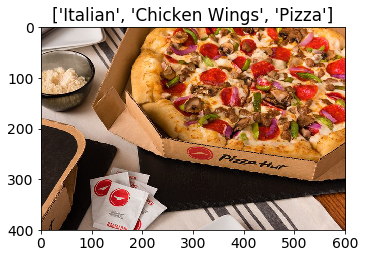

In [49]:
i = 0

for photo_id in df_photos['photo_id']:
    if photo_id == image_id:
        break
    i+=1
output_bus = photo_id_to_business[i]
i = 0
for k in ID:
    if k == output_bus:
        break
    i+=1
Cat_out = C[i]

fig, ax = plt.subplots(figsize = (12, 12))
plt.subplot(1, 2, 1)
plt.imshow(mpimg.imread("/Users/nitomar/Downloads/yelp_photos/photos/"+image_id+".jpg")[:,:,:3])
plt.title([C for C in Cat_out if C not in ['Restaurants','restaurants']])
plt.show()